In [274]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [275]:
tpf = np.zeros((1000, 11, 11))

In [276]:
tpf[:,4:7,4:7] = 200.0
tpf += 1

for i in range(1000):
    tpf[i,4,4:7] -= 200.0*i/len(tpf)
    tpf[i,7,4:7] += 200.0*i/len(tpf)

In [277]:
lc = np.sum(tpf, axis=(1,2))
yc = np.linspace(0, 1, 1000)
xc = np.zeros(1000)

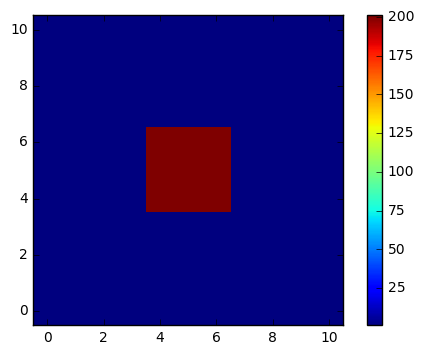

In [278]:
plt.imshow(tpf[0], origin='lower', interpolation='nearest')
plt.colorbar()

In [279]:
from scipy.interpolate import RectBivariateSpline

In [280]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

xp = np.linspace(0, 10, 44)
yp = np.linspace(0, 10, 44)

In [281]:
tpf = np.log(tpf)

In [282]:
interp = [RectBivariateSpline(x, y, tpf[i], kx=1, ky=1) for i in range(tpf.shape[0])]

In [297]:
super_tpf = np.array([interp[i](yp + (yc[i]), xp + (xc[i])) for i in range(len(xc))])

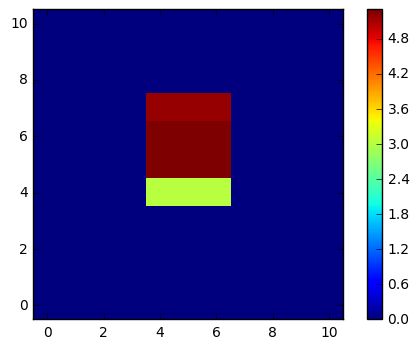

In [298]:
plt.imshow(tpf[900], origin='lower', interpolation='nearest')
plt.colorbar()

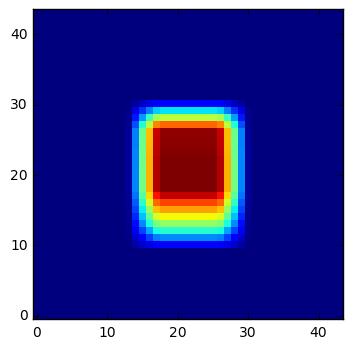

In [301]:
plt.imshow(super_tpf[900], origin='lower', interpolation='nearest')

In [302]:
mean_super_tpf = np.mean(super_tpf, axis=0)

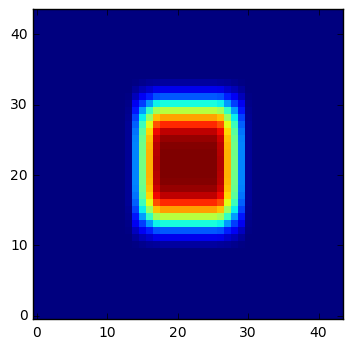

In [303]:
plt.imshow(mean_super_tpf, origin='lower', interpolation='nearest')

In [304]:
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

In [305]:
detector = np.zeros((44,44))

In [306]:
def model_prime(f, dy, dx, template):
    interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    return f * interp_again(yp - dy, xp - dx)

In [307]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, 4, 11, 4)
    return np.sum(tmp, axis=(1, 3))

In [308]:
data = tpf[0]

In [309]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s) + model(1, 0, 0, template_d) - self.data
        return np.sum(r * r * 1.0)

In [310]:
from scipy.optimize import minimize
from tqdm import tqdm

In [311]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(np.log(1e4), 0.05, 0.05), args=(norm_super_tpf, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [00:45<00:00, 21.25it/s]


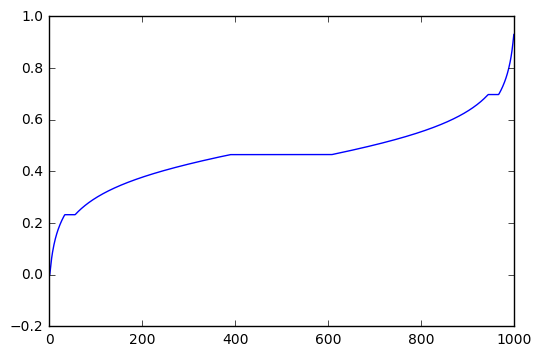

In [312]:
results = np.array(results)
plt.plot(results[:,1])

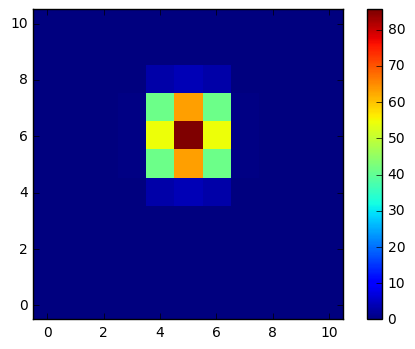

In [313]:
model_ = model(*results[-1], norm_super_tpf)
model_test = model(np.sum(tpf[-1]), results[-1][1], results[-1][2], norm_super_tpf)
plt.imshow(np.exp(model_) - np.exp(model_test), origin='lower', interpolation='nearest', cmap='jet')
plt.colorbar()

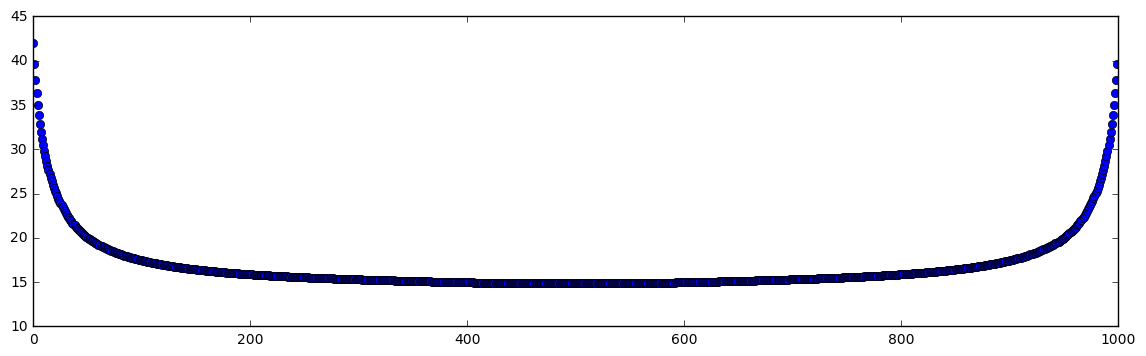

In [314]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [315]:
gds = norm_super_tpf

In [316]:
models = [model(*results[i], gds) for i in range(1000)]
interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]

In [317]:
interp_ = RectBivariateSpline(x, y, model_ - tpf[0], kx=1, ky=1)

In [346]:
dlnlike_ds = 2 * np.array([results[i, 0] * interps[i](yp - results[i, 1], xp - results[i, 2]) for i in range(1000)])

In [347]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

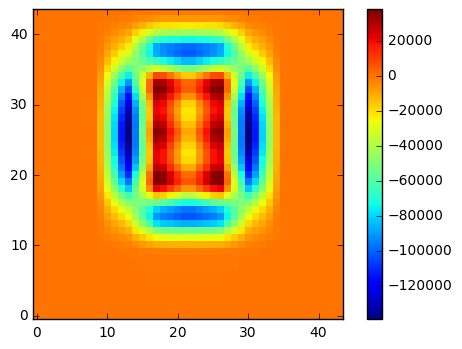

In [348]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [349]:
gds = np.copy(norm_super_tpf)

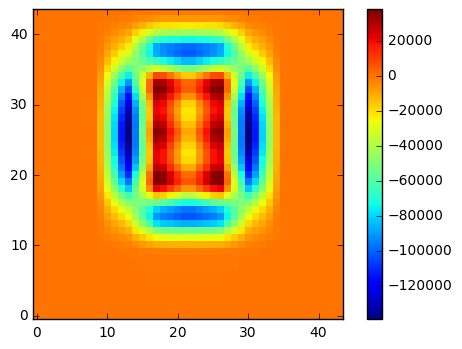

In [350]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [351]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-10
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                          for i in range(1000)])
    while j < 2000:
        tmp_s = tmp_s - c * dlnlike_ds
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
            interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
            dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
            dlnlike_ds = np.sum(dlnlike_ds, axis=0)
        else:
            c *= .25
        if c < 1e-14:
            break
        logL_before = logL_after
        j += 1
    return tmp_s

In [352]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-9
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
    while j < 2000:
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
            interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
            dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
            dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        else:
            c *= .25
        if c < 1e-14:
            break
        logL_before = logL_after
        j += 1
    return tmp_d

In [353]:
results = np.array(results)
gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))


20247.9578418
20098.247867
20098.247867
19938.6058599
19938.6058599
19768.967145
19768.967145
19589.4171167
19589.4171167
19400.22828
19400.22828
19201.902807
19201.902807
18995.2209129
18995.2209129
18781.2952368
18781.2952368
18561.6312483
18561.6312483
18338.1935101
18338.1935101
18113.4773904
18113.4773904
17890.5855761
17890.5855761
17673.3085062
17673.3085062
17466.2076659
17466.2076659
17274.7006365
17274.7006365
17105.146965
17105.146965
16964.9344416
16964.9344416
16862.5664074
16862.5664074
16807.7525003
16807.7525003
16811.5080456
16811.5080456
16822.5832433
16822.5832433
16825.9855622
16825.9855622
16826.8757369
16826.8757369
16827.1007553
16827.1007553
16827.1571645
16827.1571645
16827.1712765
16827.1712765
16827.1748051


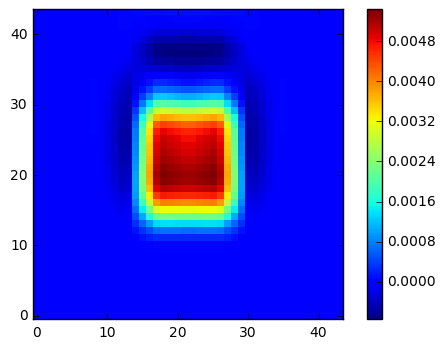

In [354]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

In [355]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

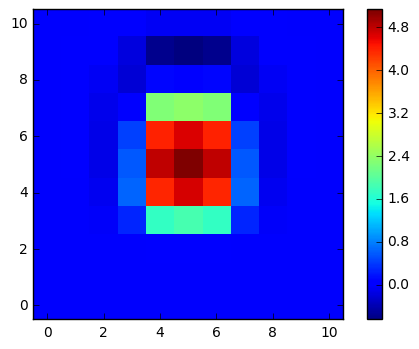

In [357]:
n=-999
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) + model(1, 0, 0, detector), origin='lower', interpolation='nearest')
plt.colorbar()

In [358]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [00:49<00:00, 18.49it/s]


In [359]:
pred_flux = [np.sum(np.exp(model(f_n[i], yc_n[i], xc_n[i], gds))) for i in range(1000)] 

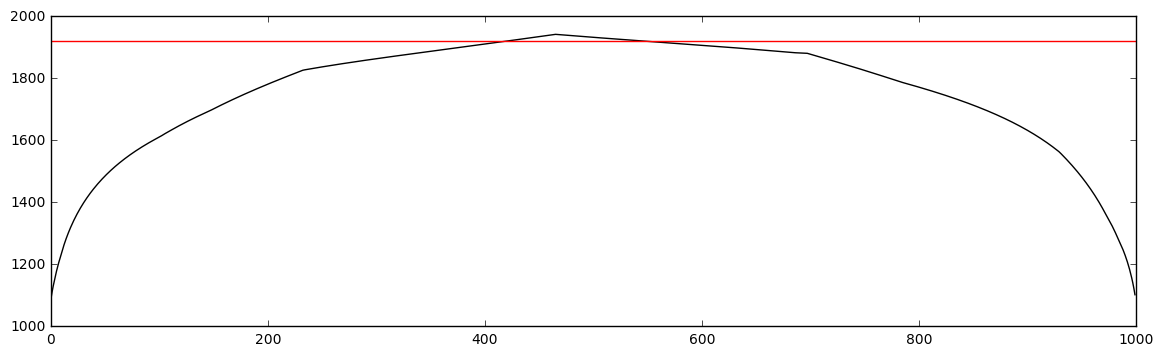

In [360]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux, 'k')
plt.plot(np.arange(1000), np.sum(np.exp(tpf), axis=(1,2)), 'r')

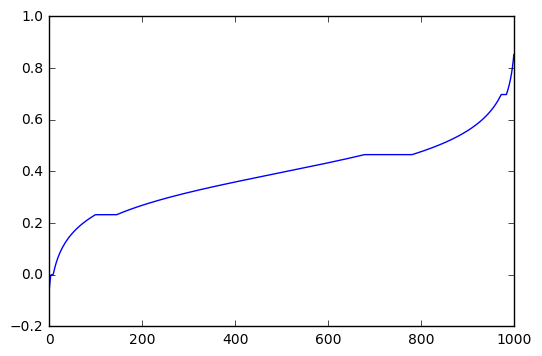

In [361]:
results = np.array(results)
plt.plot(np.arange(1000), results[:,1])

In [147]:
np.sum(np.exp(model(f_n[n], yc_n[n], xc_n[n], gds)))

1920.9999975547826

What